In [1]:
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [22]:
df1 = pd.read_csv('./data.csv')

In [43]:
test_data = df1[["smooth_soh", "start_time"]]
# test_data["start_time"] = test_data["start_time"].astype('datetime64')
test_data['start_time'] = pd.to_datetime(test_data['start_time'], format='%Y/%m/%d %H:%M', errors='coerce')

# 提取日期部分
test_data['start_time'] = test_data['start_time'].dt.date

test_data.set_index('start_time', inplace=True)
test_data.index = pd.to_datetime(test_data.index)  # 确保索引是 DatetimeIndex 类型

C:\Users\18409\AppData\Local\Temp\ipykernel_20636\2163014358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['start_time'] = pd.to_datetime(test_data['start_time'], format='%Y/%m/%d %H:%M', errors='coerce')
C:\Users\18409\AppData\Local\Temp\ipykernel_20636\2163014358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['start_time'] = test_data['start_time'].dt.date


In [44]:
weekly_soh_mean = test_data.resample('W').mean()

In [45]:
interpolated_data = weekly_soh_mean.interpolate(method='linear')

Text(0, 0.5, 'smooth_soh')

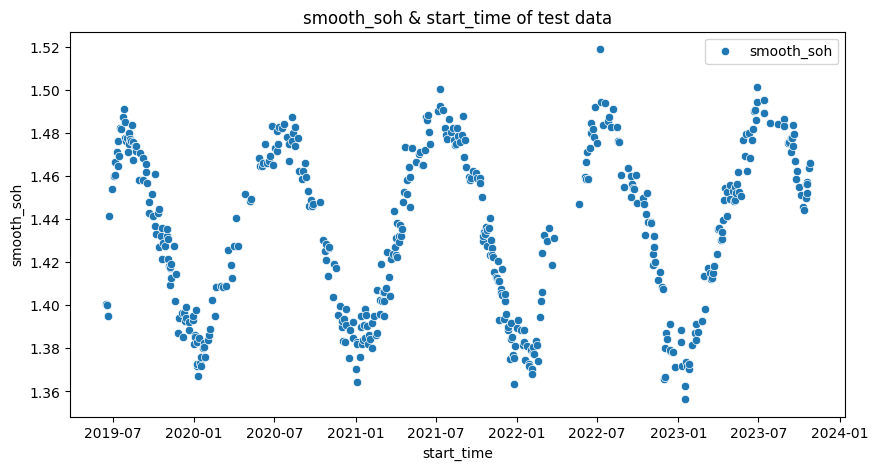

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(data=test_data, x="start_time", y="smooth_soh",label = 'smooth_soh')
plt.title('smooth_soh & start_time of test data')
plt.xlabel('start_time')
plt.ylabel('smooth_soh')

Text(0, 0.5, 'smooth_soh')

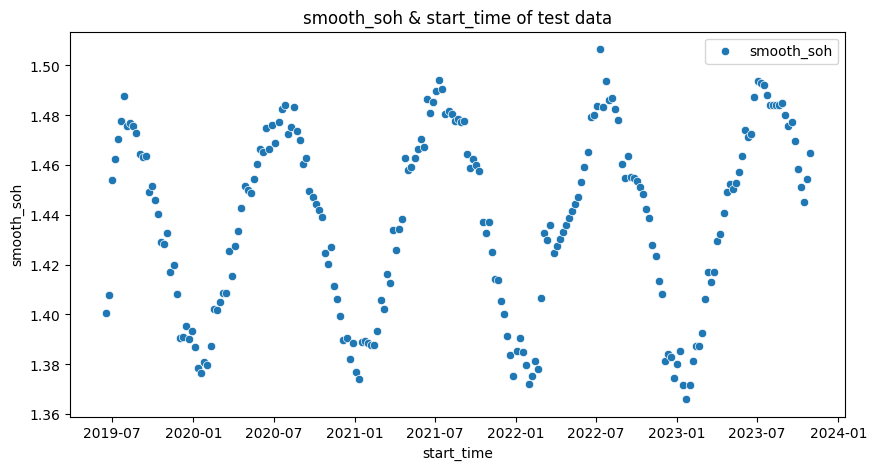

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(data=interpolated_data, x="start_time", y="smooth_soh",label = 'smooth_soh')
plt.title('smooth_soh & start_time of test data')
plt.xlabel('start_time')
plt.ylabel('smooth_soh')

d:\anaconda\envs\PYspark\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\envs\PYspark\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\envs\PYspark\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\envs\PYspark\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'smooth_soh')

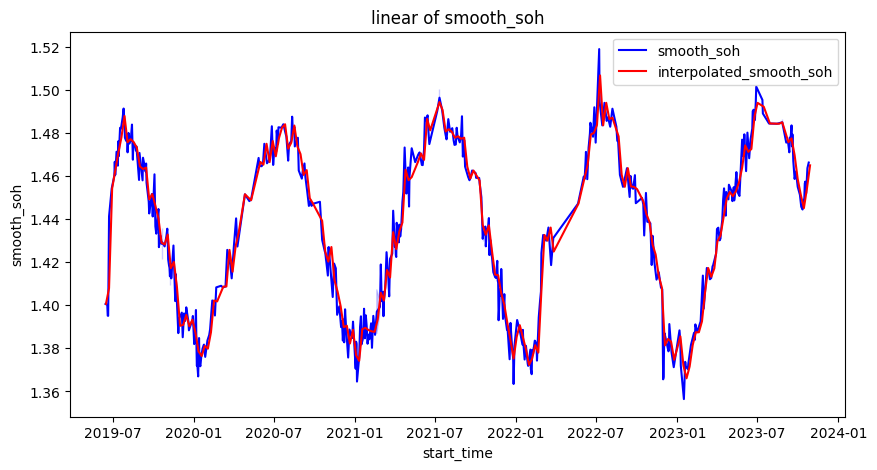

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=test_data, x="start_time", y="smooth_soh",label = 'smooth_soh',ax=axs, color='blue')
sns.lineplot(data=interpolated_data, x="start_time", y="smooth_soh",label = 'interpolated_smooth_soh',ax=axs, color='red')
plt.title("linear of smooth_soh")
plt.xlabel("start_time")
plt.ylabel("smooth_soh")

In [53]:
interpolated_data

,smooth_soh
start_time,
2019-06-16,1.400546
2019-06-23,1.407835
2019-06-30,1.454106
2019-07-07,1.462344
2019-07-14,1.470652
...,...
2023-10-01,1.458469
2023-10-08,1.451179
2023-10-15,1.445003


In [61]:
# 判断是否为白噪声
lags = [1, 4, 8, 16, 32]
print('序列的白噪声检验结果为：'+'\n',acorr_ljungbox(interpolated_data['smooth_soh'], lags))

序列的白噪声检验结果为：
         lb_stat      lb_pvalue
1    216.686278   4.777660e-49
4    763.021493  7.845698e-164
8   1170.689775  2.061852e-247
16  1285.898611  5.373011e-264
32  3305.748224   0.000000e+00


In [62]:
# 判断序列是否平稳
adf_result = adfuller(test_data["smooth_soh"])
print('ADF Statistic: %f' % adf_result[0])#ADF统计量
print('p-value: %f' % adf_result[1])#p值
print('Critical Values:')#在置信水平下的临界值
for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
print()

ADF Statistic: -4.696326
p-value: 0.000086
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570



In [65]:
decomposition = seasonal_decompose(interpolated_data, period=100, model = 'additive')

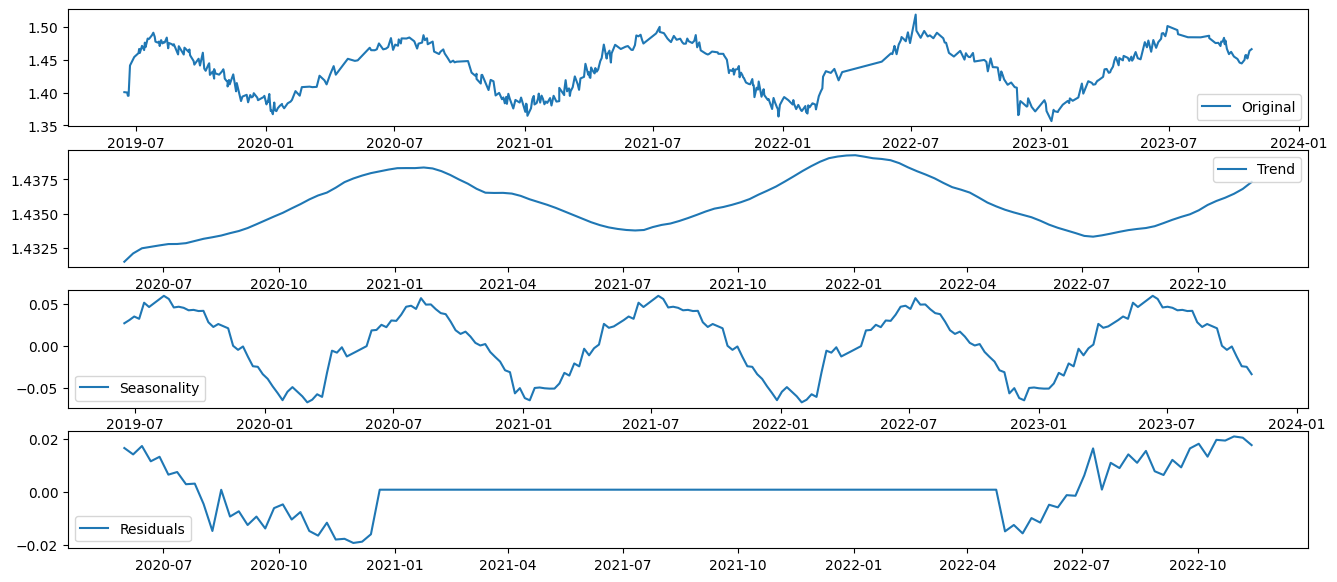

In [66]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
plt.figure(figsize=(16,7))
fig = plt.figure(1)
 
plt.subplot(411)
plt.plot(test_data, label='Original')
plt.legend(loc='best')


plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

date_format = DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()


C:\Users\18409\AppData\Local\Temp\ipykernel_20636\4269429611.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = ts_log_diff.resample('M').mean()
C:\Users\18409\AppData\Local\Temp\ipykernel_20636\4269429611.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_ = ts_log_diff.resample('M').std()


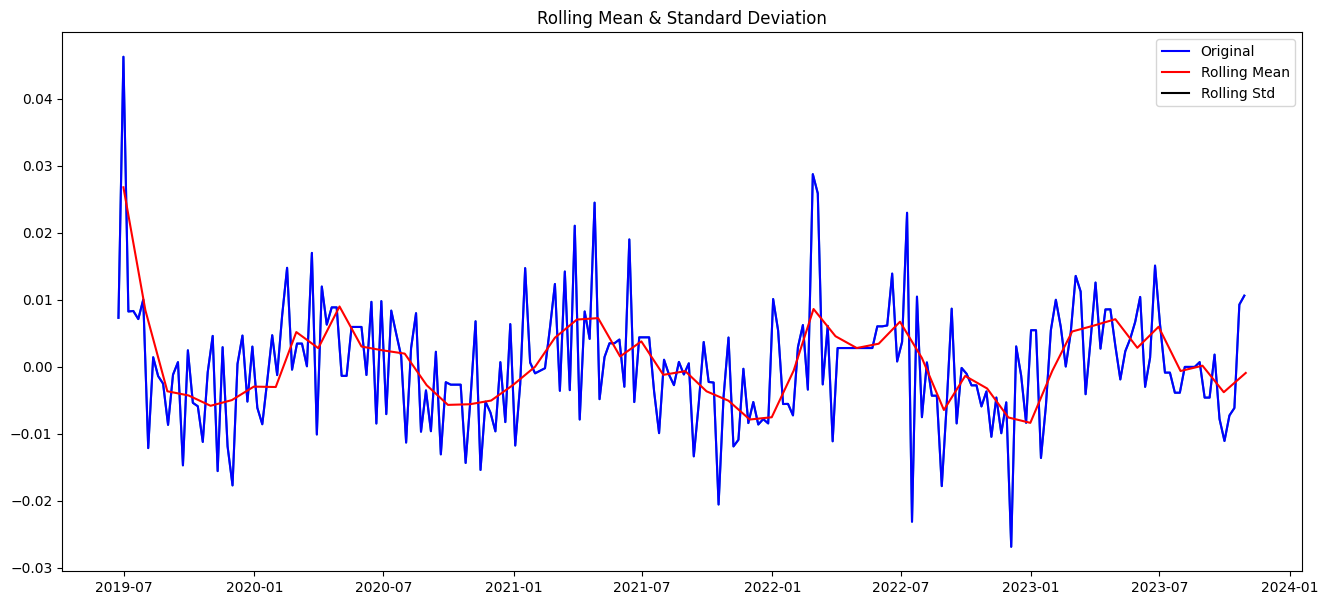

In [67]:
# differencing 对数据进行一阶差分---如果为白噪声序列，需差分，该数据集不需要，可忽略该步骤
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = interpolated_data - interpolated_data.shift()
plt.plot(ts_log_diff)


# 重采样到每月
df_monthly = ts_log_diff.resample('M').mean()
df_monthly_ = ts_log_diff.resample('M').std()
rolLmean = df_monthly.rolling(window=1).mean()
rolLstd = df_monthly_.rolling(window=1).std()


#Determing rolling statistics
# rolLmean = ts_log_diff.rolling('30D').mean()
# rolLstd = ts_log_diff.rolling('30D').std()
 
#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

d:\anaconda\envs\PYspark\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


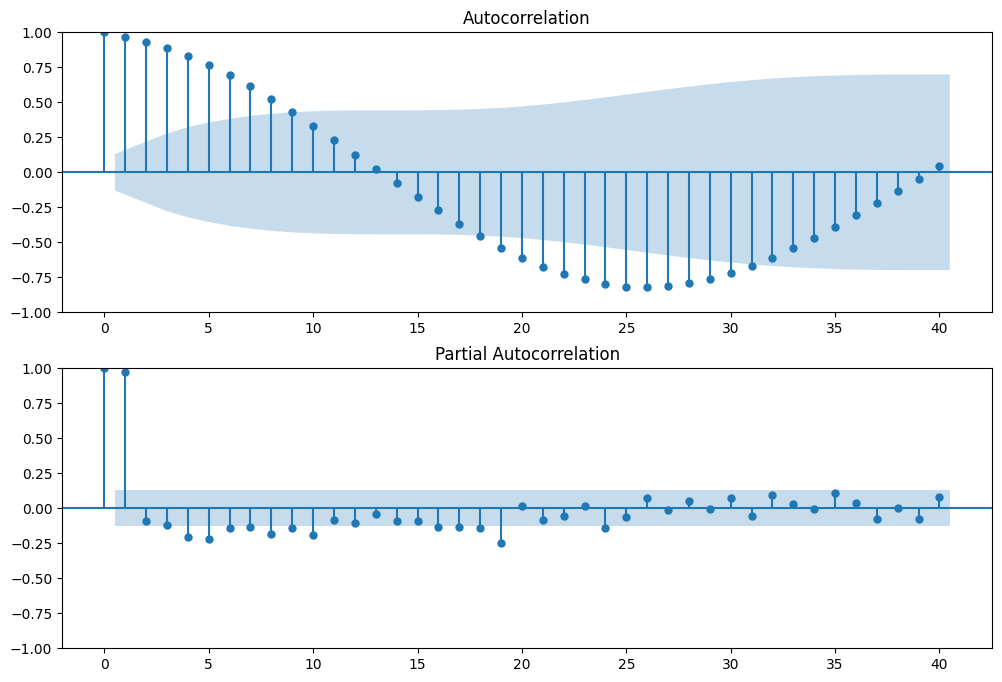

In [68]:
#计算自相关函数（ACF）和偏自相关函数（PACF）
df1.sort_index(inplace= True)

lag_acf = acf(interpolated_data, nlags=20)
lag_pacf = pacf(interpolated_data, nlags=20)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(interpolated_data.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(interpolated_data.dropna(),lags=40,ax=ax2)

In [69]:
# 切分数据集，以后十个数据作为预测值
length = len(interpolated_data)

train_data = interpolated_data.iloc[:-10, :]
label = interpolated_data.iloc[-10:, :]

start_time
2019-06-16    1.436696
2019-06-23    1.401588
2019-06-30    1.408667
2019-07-07    1.453604
2019-07-14    1.461605
Freq: W-SUN, dtype: float64
start_time
2019-06-16    1.436696
2019-06-23    2.838284
2019-06-30    4.246951
2019-07-07    5.700555
2019-07-14    7.162160
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE: 2924883347438246401079359575126005907483309610948118303208628764469978902117812199900726657091194858114636282561594465730609731359211520.0000')

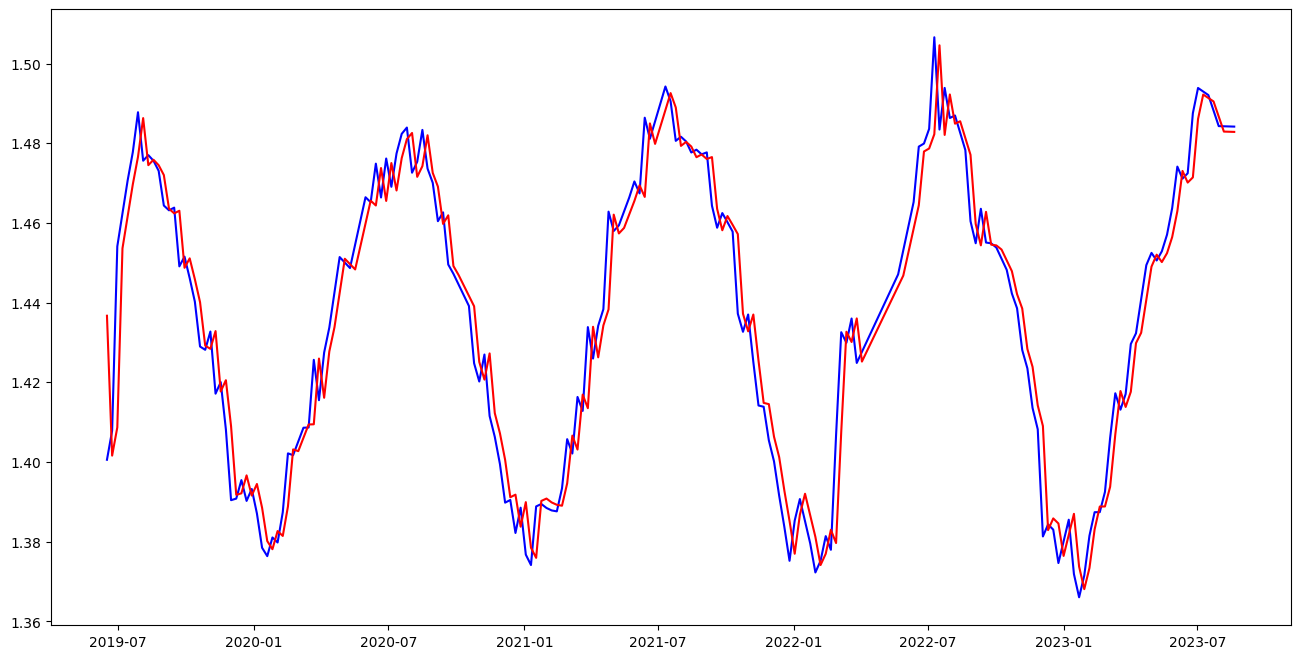

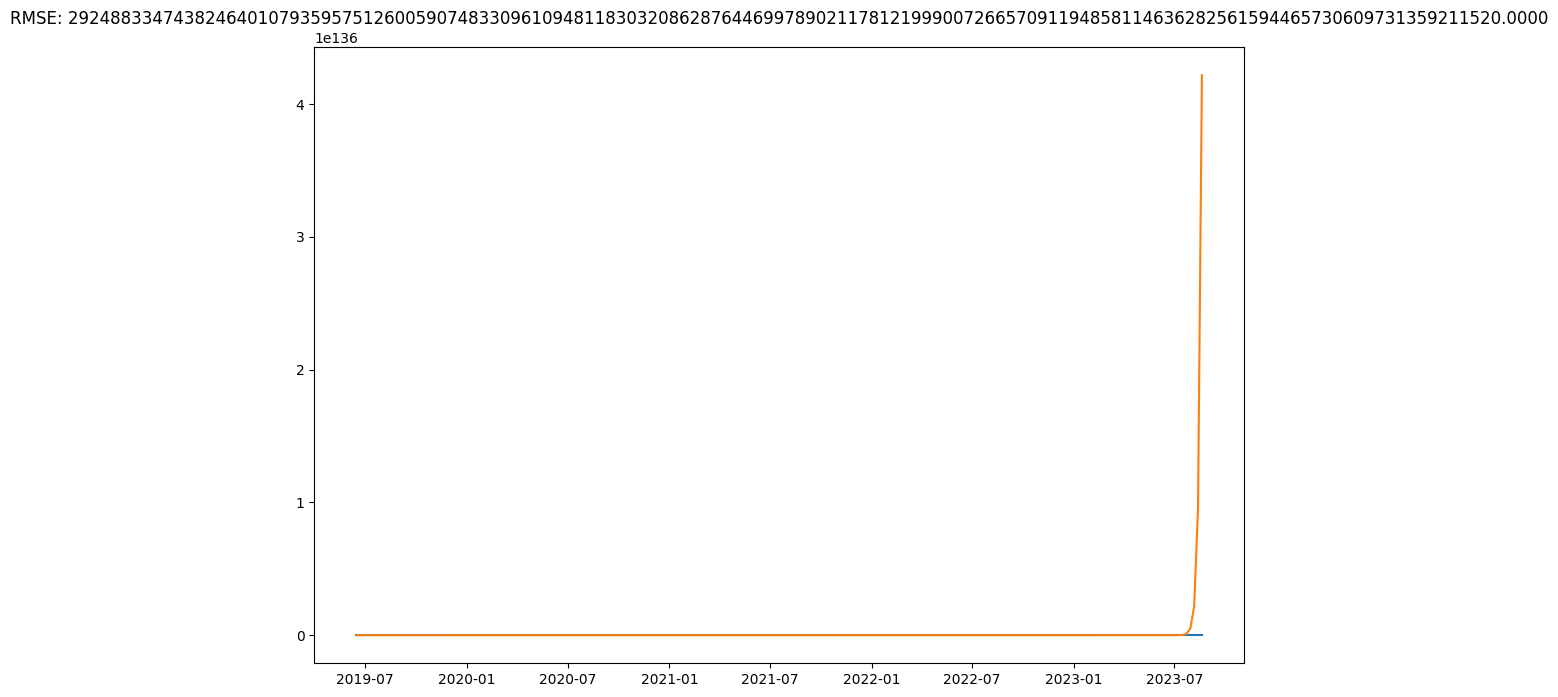

In [73]:
#建立ARIMA模型
#from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA
type(train_data)
#ts_log_diff.dropna()
test_data = train_data[~train_data.isnull()]
plt.figure(figsize=(16,8))
#ts_log_diff.dropna(inplace=True)
model = ARIMA(train_data, order=(1,0,0))  
results_ARIMA = model.fit()  
plt.plot(train_data, label='Training', color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
 
#模型拟合 预测
 
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())
 
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())
 
ARIMA_log_prediction = pd.Series(train_data.iloc[0], index=train_data.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()
 
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(train_data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train_data['smooth_soh'])**2)/len(train_data['smooth_soh'])))

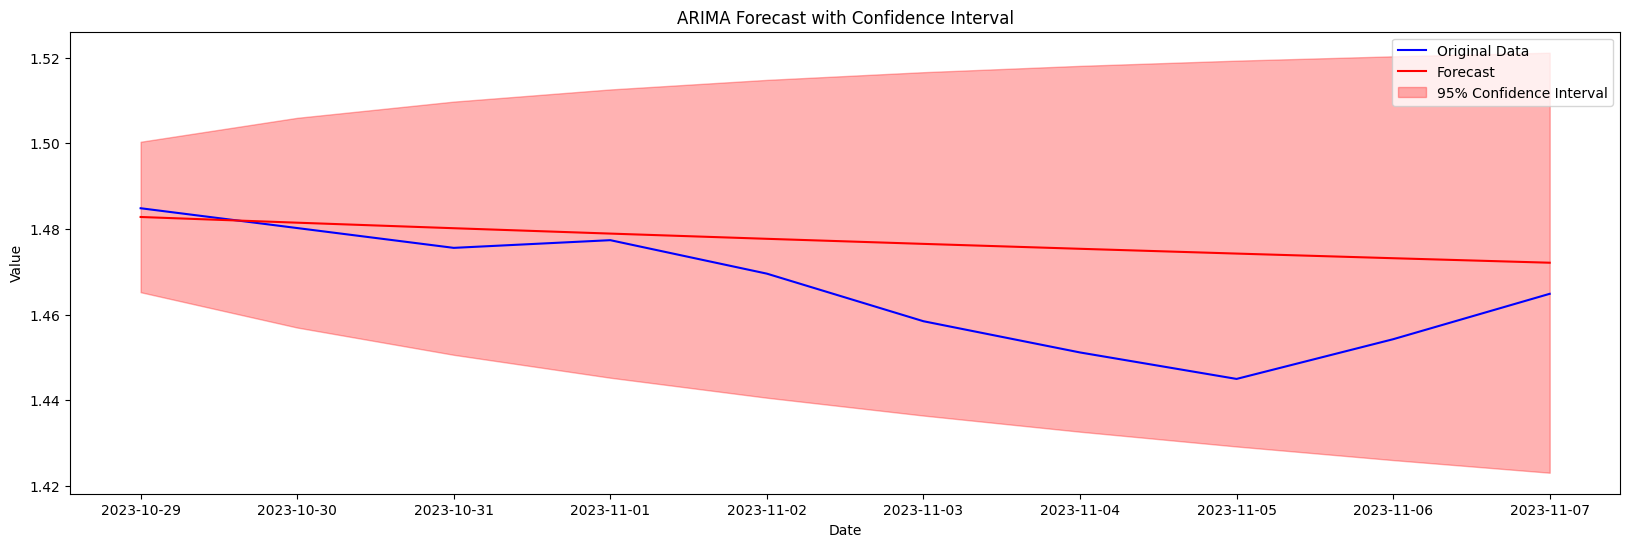

In [74]:
# 进行未来 10 步的预测
forecast_result = results_ARIMA.get_forecast(steps=10, alpha=0.05)  # 设置置信水平为 95%
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 绘制预测结果和95%置信区间
plt.figure(figsize=(20, 6))
# plt.plot(label.index, label, label='Original Data')
plt.plot(pd.date_range(start=label.index[-1], periods=10, freq='D'), label, color="blue", label='Original Data')
plt.plot(pd.date_range(start=label.index[-1], periods=10, freq='D'), forecast, color='red', label='Forecast')
plt.fill_between(pd.date_range(start=label.index[-1], periods=10, freq='D'), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [77]:
# # 检测异常值
# # 先根据时间字段排序
# test_data = df1[["smooth_soh", "start_time"]]
# test_data = test_data.sort_values(by='start_time')

# # 将时间字段转换为时间类型
# test_data['start_time'] = pd.to_datetime(test_data['start_time'])

# # 以时间字段为索引
# test_data = test_data.set_index('start_time')

# 用 ARIMA 模型检测异常值
def detect_anomalies(series):
    model = ARIMA(series, order=(2, 0, 0))  # 选择适当的 ARIMA 参数
    results = model.fit()
    residuals = results.resid
    std_dev = residuals.std()
    anomalies = (residuals > 2 * std_dev) | (residuals < -2 * std_dev)
    return anomalies

# 对每个车辆 vin 进行异常值检测
anomalies_indices = []

anomalies = detect_anomalies(interpolated_data['smooth_soh'])
anomalies_indices.extend(interpolated_data[anomalies].index)

# 输出异常值的索引
print(anomalies_indices)
# print(test_data[test_data["start_time"].isin(anomalies_indices)])
# 输出异常值的索引及其对应的值
for index in anomalies_indices:
    value = interpolated_data.loc[index, 'smooth_soh']
    print(f"Index: {index}, Value: {value}")

[Timestamp('2019-06-16 00:00:00'), Timestamp('2019-06-30 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-04-25 00:00:00'), Timestamp('2021-06-13 00:00:00'), Timestamp('2021-10-17 00:00:00'), Timestamp('2022-02-27 00:00:00'), Timestamp('2022-03-06 00:00:00'), Timestamp('2022-07-10 00:00:00'), Timestamp('2022-07-17 00:00:00'), Timestamp('2022-12-04 00:00:00')]
Index: 2019-06-16 00:00:00, Value: 1.400545724
Index: 2019-06-30 00:00:00, Value: 1.454106226
Index: 2021-03-28 00:00:00, Value: 1.4338418554999999
Index: 2021-04-25 00:00:00, Value: 1.4628193285
Index: 2021-06-13 00:00:00, Value: 1.4863984805000001
Index: 2021-10-17 00:00:00, Value: 1.4372084459999999
Index: 2022-02-27 00:00:00, Value: 1.406686061
Index: 2022-03-06 00:00:00, Value: 1.432562715
Index: 2022-07-10 00:00:00, Value: 1.5065859
Index: 2022-07-17 00:00:00, Value: 1.483425762
Index: 2022-12-04 00:00:00, Value: 1.3812945561999999


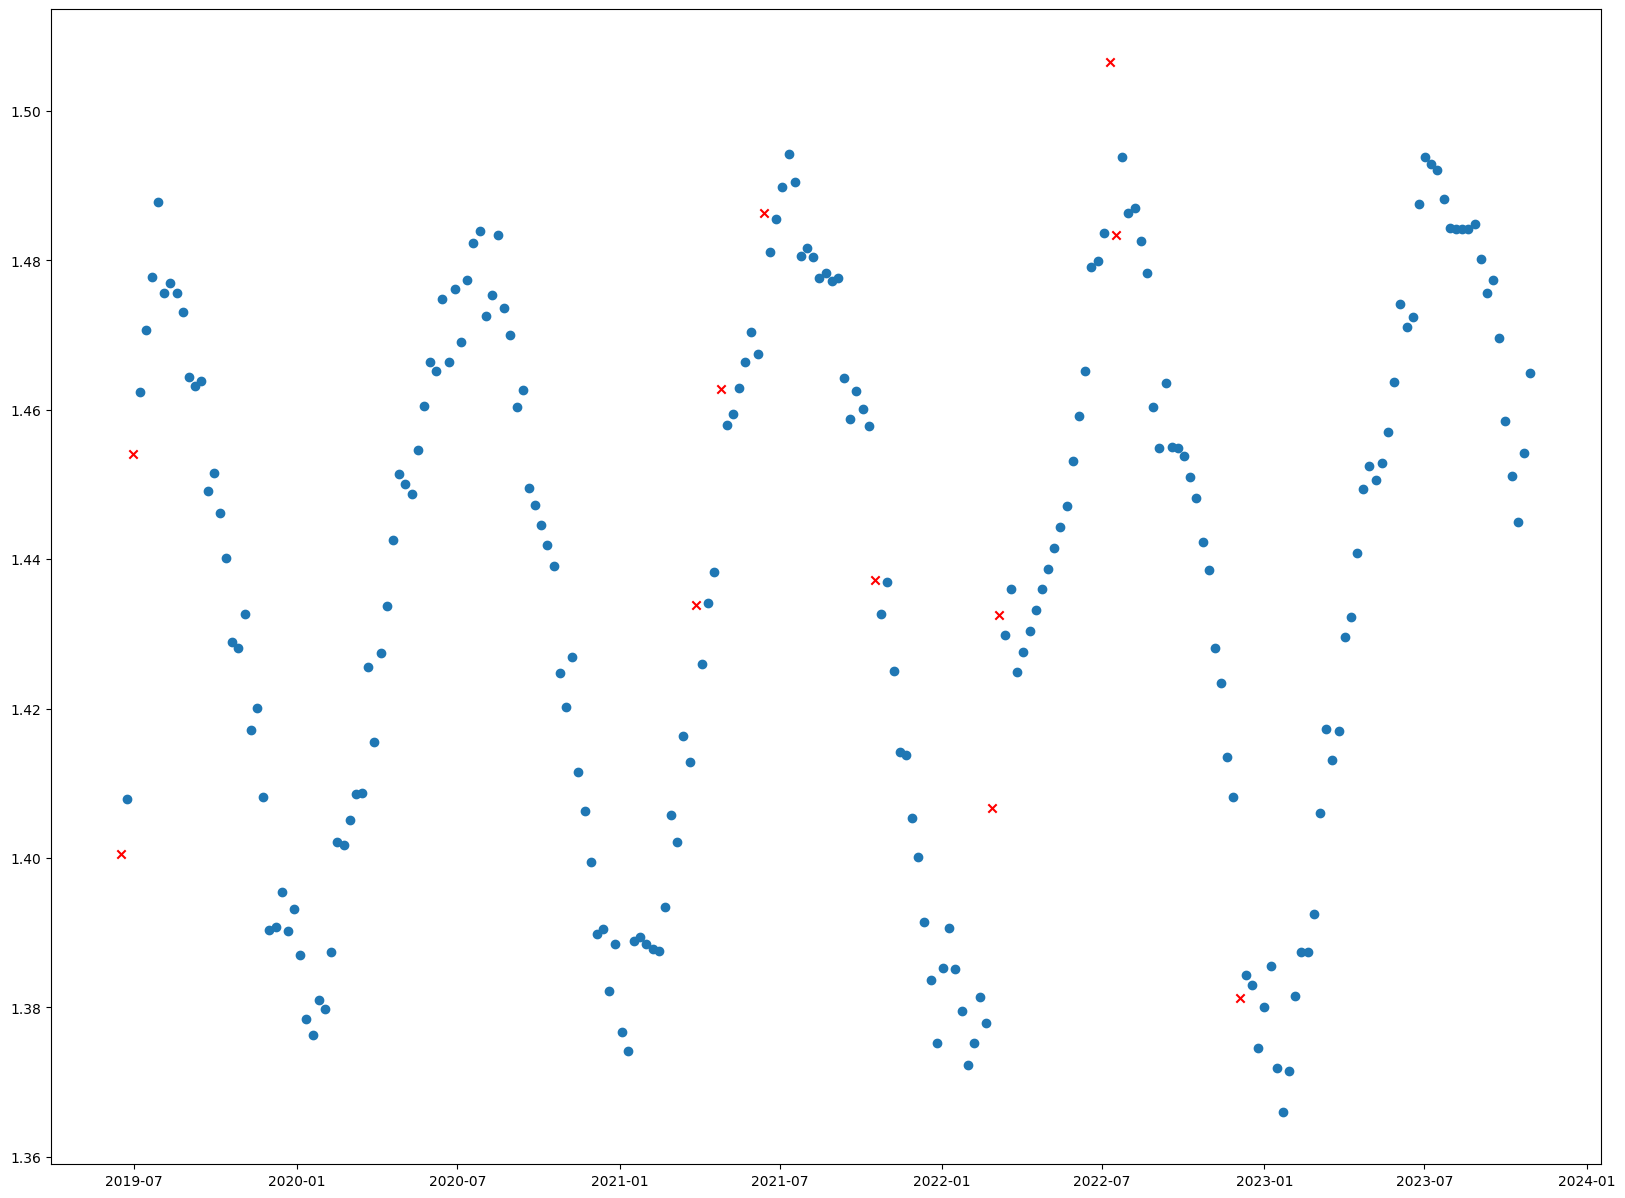

In [78]:
# 显示异常值
fig, axs = plt.subplots(figsize=(20, 15))

# 提取list中对应的index
list_vals_index = pd.to_datetime(anomalies_indices)

# 筛选出不包含异常值的数据
df_filtered = interpolated_data[~interpolated_data.index.isin(list_vals_index)]
plt.scatter(x=df_filtered.index, y=df_filtered['smooth_soh'], label='smooth_soh')

# 提取list中的数据并标红
plt.scatter(list_vals_index, interpolated_data.loc[list_vals_index, 'smooth_soh'], color='red', label='Anomalies', marker='x')